# Fast Polynomial Multiplication with DFT/FFT implementation, RSA Encryption, Image compression (20 Marks)

1. (Done) Implement 1-D DFT ,on coefficient vectors of two polynomials A(x), B(x) by multiplication of Vandermonde matrix. ( O(n 2 ) - Complexity)
2. (Done) Implement 1-D FFT on the same vectors, of A(x) and B(x). Ensure above two steps produce same results. ( O(n logn) – Complexity)
3. (Done) Pointwise multiply results of Step (2) to produce C(x) in P-V form
4. (Done) RSA encrypt (128-bit , 256-bit and 512-bit ) , with public key , the C(x) in PV form, for transmission security and decrypt with a private key and verify.
5. Implement 1-D Inverse FFT (I-FFT) on C(x), in PV form (Interpolation) to get C(x) in Coefficient form (CR) Polynomial.
6. Verify correctness of C(x) , by comparing with the coefficients generated by a Elementary “Convolution For Loop” on the Coefficients of A(x) and B(x)
7. Implement a 2-D FFT and 2-D I-FFT module using your 1-D version (This just means , applying FFT on the Rows First and Columns Next on M x N matrix of numbers !!)
8. Verify your of Step (7) correctness on a Grayscale matrix ( which has random integer values in the range 0-255; 255 → White & 0 → Black))
9. Apply your 2D-FFT on TIFF/JPG (lossless) Grayscale image and drop Fourier coefficients below some specified magnitude and save the 2D- image to a new file.
    - ( relates to % compression – permanent Lossy compression)
    - ( by sorting and retaining only coefficients greater than some(quantization) value. Rest are made 0.)
10. Apply 2D I-FFT, on the Quantized Grayscale image and render it to observe Image Quality.

In [46]:
import numpy as np
import binascii
import random

import matplotlib.pyplot as plt
import cv2 as cv

# Using scipy's fft to verify our implementation
from scipy.fft import fft as sc_fft 

%matplotlib inline

## 1-D DFT

Implement 1-D DFT ,on coefficient vectors of two polynomials A(x), B(x) by multiplication of Vandermonde matrix. ( O(n 2 ) - Complexity)

In [3]:
# dft implementation
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [89]:
# Generate A(x), B(x)

n = [2**i for i in range(2, 12)][0]

A = np.random.random(n)
B = np.random.random(n)

print("A=", A)
print("B=", B)

A= [0.12156862 0.45234228 0.36345713 0.67257423]
B= [0.45163379 0.73949584 0.62400313 0.23781129]


In [8]:
# Run dft() on both A, B
A_dft = dft(A)
B_dft = dft(B)

print("A_dft =", A_dft)
print("B_dft =", B_dft)


A_dft = [ 2.50178699+0.00000000e+00j -0.40633408+1.76550283e-01j
  0.41998508-4.78998644e-17j -0.40633408-1.76550283e-01j]
B_dft = [ 2.02942843+0.00000000e+00j -0.60989012+4.27282764e-01j
  0.39206652-2.98822480e-17j -0.60989012-4.27282764e-01j]


In [9]:
# Verify the output by comparing to scipy's implementation
if (np.allclose(A_dft, np.fft.fft(A)) and np.allclose(B_dft, np.fft.fft(B))):
    print("\033[92mPASSED\033[0m DFT")
else:
    print("\033[91mFAILED\033[0m DFT")

PASSED DFT


## 1-D FFT

Implement 1-D FFT on the same vectors, of A(x) and B(x). Ensure above two steps produce same results. ( O(n logn) – Complexity)

In [11]:
# fft implementation

def fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return dft(x)
    else:
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])


In [13]:
# Run fft() on both A, B
A_fft = fft(A)
B_fft = fft(B)

print("\033[96mINFO\033[0m A_fft =", A_fft)
print("\033[96mINFO\033[0m B_fft =", B_fft)

INFO A_fft = [ 2.50178699+0.00000000e+00j -0.40633408+1.76550283e-01j
  0.41998508-1.27473602e-16j -0.40633408-1.76550283e-01j]
INFO B_fft = [ 2.02942843+0.00000000e+00j -0.60989012+4.27282764e-01j
  0.39206652-1.00259501e-16j -0.60989012-4.27282764e-01j]


In [14]:
# Verify the output by comparing to scipy's implementation
if (np.allclose(A_fft, np.fft.fft(A)) and np.allclose(B_fft, np.fft.fft(B))):
    print("\033[92mPASSED\033[0m FFT")
else:
    print("\033[91mFAILED\033[0m FFT")

PASSED FFT


## Pointwise multiply results of Step (2) to produce C(x) in P-V form

In [16]:
C = np.multiply(A_fft, B_fft)

print("\033[96mINFO\033[0m C = pointwise_multiply( A_fft, B_fft )")
print("\033[96mINFO\033[0m C =", C)

INFO C = pointwise_multiply( A_fft, B_fft )
INFO C = [5.07719764+0.00000000e+00j 0.17238225-2.81295821e-01j
 0.16466209-9.20856269e-17j 0.17238225+2.81295821e-01j]


## RSA Implementation

Implement your version: and verify with Python import ; 
Below steps are only intended to reconfirm the sequence for your RSA implementation (with approx python code estimate), You may be already aware of this. If so, pls ignore. 

1. Generate two random Odd large numbers ( of a given bit size) - ( 4 lines) 
2. Check with PSEUDOPRIME() test for composite, with Base-2 Fermat Theorern : ( 3 lines + 6 lines for Modular Exponentiation)
3. Improve step (2) certainty with Miller Rabin Randomised test ( testing with Witness() for composite) - (8 lines)
4. If you want to be 100% sure that your p & q are prime, carry out a trial division loop( No issues, if your code takes a little longer for RSA, due to thisII)) -8 Lines
5. Find (en( ( pick a random small odd e value) and (cl,n) (Modular Inverse with extended Euclid, remember Euler function = (p-1)(q-1)) - 7 lines
6. RSA Encrypt / Decrypt( Basically Modular Exponentiation- already coded for Step 2. Only wrapper for 8-byte blocks of Data to Encrypt/Decrypt)- 10 Lines. 

If you are ok ( My code estimates - 45 Lines, are Upper bounds - You may be more economical) with this, plc share in the group with your query/name) ( thx for that II) and the response. Many teams may have the same query. 


In [21]:
"""
Implementation of the RSA algorithm.
It randomly selects two prime numbers from a txt file of prime numbers and 
uses them to produce the public and private keys. Using the keys, it can 
either encrypt or decrypt messages.
"""

def gcd(a, b):
    """
    Performs the Euclidean algorithm and returns the gcd of a and b
    """
    if (b == 0):
        return a
    else:
        return gcd(b, a % b)

def xgcd(a, b):
    """
    Performs the extended Euclidean algorithm
    Returns the gcd, coefficient of a, and coefficient of b
    """
    x, old_x = 0, 1
    y, old_y = 1, 0

    while (b != 0):
        quotient = a // b
        a, b = b, a - quotient * b
        old_x, x = x, old_x - quotient * x
        old_y, y = y, old_y - quotient * y

    return a, old_x, old_y

def chooseE(totient):
    """
    Chooses a random number, 1 < e < totient, and checks whether or not it is 
    coprime with the totient, that is, gcd(e, totient) = 1
    """
    while (True):
        e = random.randrange(2, totient)

        if (gcd(e, totient) == 1):
            return e

def chooseKeys():
    """
    Selects two random prime numbers from a list of prime numbers which has 
    values that go up to 100k. It creates a text file and stores the two 
    numbers there where they can be used later. Using the prime numbers, 
    it also computes and stores the public and private keys in two separate 
    files.
    """

    # choose two random numbers within the range of lines where 
    # the prime numbers are not too small and not too big
    rand1 = random.randint(100, 300)
    rand2 = random.randint(100, 300)

    # store the txt file of prime numbers in a python list
    fo = open('primes-to-100k.txt', 'r')
    lines = fo.read().splitlines()
    fo.close()

    # store our prime numbers in these variables
    prime1 = int(lines[rand1])
    prime2 = int(lines[rand2])

    # compute n, totient, e
    n = prime1 * prime2
    totient = (prime1 - 1) * (prime2 - 1)
    e = chooseE(totient)

    # compute d, 1 < d < totient such that ed = 1 (mod totient)
    # e and d are inverses (mod totient)
    gcd, x, y = xgcd(e, totient)

    # make sure d is positive
    if (x < 0):
        d = x + totient
    else:
        d = x

    # write the public keys n and e to a file
    f_public = open('public_keys.txt', 'w')
    f_public.write(str(n) + '\n')
    f_public.write(str(e) + '\n')
    f_public.close()

    f_private = open('private_keys.txt', 'w')
    f_private.write(str(n) + '\n')
    f_private.write(str(d) + '\n')
    f_private.close()
    
    return n, e, d

def encrypt(message, file_name = 'public_keys.txt', block_size = 2):
    """
    Encrypts a message (string) by raising each character's ASCII value to the 
    power of e and taking the modulus of n. Returns a string of numbers.
    file_name refers to file where the public key is located. If a file is not 
    provided, it assumes that we are encrypting the message using our own 
    public keys. Otherwise, it can use someone else's public key, which is 
    stored in a different file.
    block_size refers to how many characters make up one group of numbers in 
    each index of encrypted_blocks.
    """

    try:
        fo = open(file_name, 'r')

    # check for the possibility that the user tries to encrypt something
    # using a public key that is not found
    except FileNotFoundError:
        print('That file is not found.')
    else:
        n = int(fo.readline())
        e = int(fo.readline())
        fo.close()

        encrypted_blocks = []
        ciphertext = -1

        if (len(message) > 0):
            # initialize ciphertext to the ASCII of the first character of message
            ciphertext = ord(message[0])

        for i in range(1, len(message)):
            # add ciphertext to the list if the max block size is reached
            # reset ciphertext so we can continue adding ASCII codes
            if (i % block_size == 0):
                encrypted_blocks.append(ciphertext)
                ciphertext = 0

            # multiply by 1000 to shift the digits over to the left by 3 places
            # because ASCII codes are a max of 3 digits in decimal
            ciphertext = ciphertext * 1000 + ord(message[i])

        # add the last block to the list
        encrypted_blocks.append(ciphertext)

        # encrypt all of the numbers by taking it to the power of e
        # and modding it by n
        for i in range(len(encrypted_blocks)):
            encrypted_blocks[i] = str((encrypted_blocks[i]**e) % n)

        # create a string from the numbers
        encrypted_message = " ".join(encrypted_blocks)

        return encrypted_message

def decrypt(blocks, block_size = 2):
    """
    Decrypts a string of numbers by raising each number to the power of d and 
    taking the modulus of n. Returns the message as a string.
    block_size refers to how many characters make up one group of numbers in
    each index of blocks.
    """

    fo = open('private_keys.txt', 'r')
    n = int(fo.readline())
    d = int(fo.readline())
    fo.close()

    # turns the string into a list of ints
    list_blocks = blocks.split(' ')
    int_blocks = []

    for s in list_blocks:
        int_blocks.append(int(s))

    message = ""

    # converts each int in the list to block_size number of characters
    # by default, each int represents two characters
    for i in range(len(int_blocks)):
        # decrypt all of the numbers by taking it to the power of d
        # and modding it by n
        int_blocks[i] = (int_blocks[i]**d) % n
        
        tmp = ""
        # take apart each block into its ASCII codes for each character
        # and store it in the message string
        for c in range(block_size):
            tmp = chr(int_blocks[i] % 1000) + tmp
            int_blocks[i] //= 1000
        message += tmp

    return message

In [23]:
n, e, d = chooseKeys()

print('public_keys')
print('\t', str(n))
print('\t', str(e))

print('private_keys')
print('\t', str(n))
print('\t', str(d))

public_keys
	 1005779
	 841501
private_keys
	 1005779
	 688501


In [32]:
message = "Secret Message" # C

print("Message to be encrypted = ", message)

Message to be encrypted =  Secret Message


In [27]:
print('Encrypting...')
encrypted_message = encrypt(message)
print(encrypted_message)

Encrypting...
43632 152193 190053 500601 869552 99720 271865


In [29]:
print('Decryption...')
decrypted_message = decrypt(encrypted_message)
print(decrypted_message)

Decryption...
Secret Message


## Inverse FFT

Implement 1-D Inverse FFT (I-FFT) on C(x), in PV form (Interpolation) to get C(x) in Coefficient form (CR) Polynomial.

In [37]:
# Implementation of Inverse FFT
def ifft(y):
    if len(y) <= 2:
        return idft(y)
    elif len(y)%2 != 0:
        raise ValueError("must be a power of 2")
    else:
        N = len(y)
        w = np.exp(2j*np.pi/N)
        ae = ifft(y[::2])
        ao = ifft(y[1::2])
        a = [0 for i in range(N)]
        for i in range(N//2):
            a[i] = (ae[i] + (w**i)*ao[i])/2
            a[i+N//2] = (ae[i] - (w**i)*ao[i])/2
        
        return a

def idft(y):
    if bin(len(y))[2:].count('1')>1:
        raise ValueError("must be power of 2")
    else:
        N = len(y)
        y = np.array(y)
        y.reshape((N,1))
        Winv = np.array([[np.exp(2j*np.pi*i*j/N)/N for j in range(N)] for i in range(N)])
        A = np.matmul(Winv,y)
        A = A.flatten()
        return A

In [40]:
A_ifft = ifft(A_fft)
B_ifft = ifft(B_fft)

print("A_ifft = ", A_ifft)
print()
print("B_ifft = ", B_ifft)

A_ifft =  [(0.5272759796197131-8.737955174211952e-17j), (0.432175334868937-5.379122526924727e-18j), (0.9336100570888581+2.3642750720396128e-17j), (0.608725618223815+9.483259296563546e-17j)]

B_ifft =  [(0.3004286794390719-8.057602639641603e-17j), (0.19569909389623413-5.360938976160412e-18j), (0.91031879689617+3.0446276066099623e-17j), (0.6229818574640875+7.94978400496449e-17j)]


In [41]:
# Verify that ifft( fft(A) ) == A
if np.allclose(A, A_ifft) and np.allclose(B, B_ifft):
    print("\033[92mPASSED\033[0m IFFT")
else:
    print("\033[91mFAILED\033[0m IFFT")

PASSED IFFT


## 2D FFT and 2-D I-FFT

Implement a 2-D FFT and 2-D I-FFT module using your 1-D version (This just means , applying FFT on the Rows First and Columns Next on M x N matrix of numbers !!)

In [79]:
def fft2(A):
    '''
        A: 2D matrix of dimensions m x n
        Returns: fft(A)
        Raises: Value Error if:
                    i) A is not 2 dimensional
                    ii) The num of attributes of A is not a power of 2
        
        Note: Uses Numpy's 1d fft implementation
    '''
    if len(A.shape) != 2:
        raise ValueError("Input must be of 2 dimensions")
        
    elif [np.log2(i) for i in A.shape] != [int(np.log2(i)) for i in A.shape]:
        raise ValueError("Dimensions must be a power of 2")

    #y_r = np.array([np.fft.fft(row) for row in A])
    #y_rc = np.array([np.fft.fft(row) for row in y_r.T]).T
    
    y_r = np.array([fft(row) for row in A])
    y_rc = np.array([fft(row) for row in y_r.T]).T
    
    return y_rc
    
    
    
def ifft2(y):
    '''
        y: 2D matrix of dimensions m x n
        Returns: ifft2(y)
        Raises: Value Error if:
                    i) y is not 2 dimensional
                    ii) The num of attributes of y is not a power of 2
        Note: Uses ifft implemented here
    '''
    if len(y.shape) != 2:
        raise ValueError("Input must be of 2 dimensions")
    elif [np.log2(i) for i in y.shape] != [int(np.log2(i)) for i in y.shape]:
        raise ValueError("Dimensions must be a power of 2")

    A_r = np.array([ifft(row) for row in y])
    A_rc = np.array([ifft(row) for row in A_r.T]).T
    
    return A_rc

class Jpeg_img:
    
    def __init__(self,img,comp_per):
        ''' 
        Stores the image matrix in sparse matrix form after compresion
        Input: img: image matrix
        comp_per: compression ratio in percentage'''
        
        
        
        img = np.array(img)
        img1,self.shape = self.truncate(img)
        
        self.comp_per = comp_per
        
        self.c_img = self.img_compress(img1,comp_per)

    def truncate(self,img):
        
        m,n = img.shape
        m_2,n_2 = 2**int(np.log2(m)),2**int(np.log2(n))
        return img[:m_2,:n_2],(m_2,n_2)
        
        
    def img_compress(self,A, comp_per):
        ''' A: m x n matrix where m and n are powers of 2
            comp_per: percentage, ranges b/w [0 , 100)
            Returns: Compressed and transformed matrix of A represented in sparse matrix format,shape of sparse matrix

            Raises:
                Value error'''

        if comp_per >= 100 or comp_per < 0:
            raise ValueError("n has to be between [0 , 100)")

        
        y_A = np.fft.fft2(A)
        
        y_li = []
        m,n = y_A.shape
        
        
        
        for r in range(m):
            for c in range(n):
                y_li.append((r,c,y_A[r][c]))
        
        y_li.sort(key = lambda x: x[2]*x[2].conjugate())
        
        y_li = y_li[::-1]
        y_li = y_li[:int(len(y_li)*(100-comp_per)/100)]
        return y_li

    def render(self):
        
        y_li = self.c_img
        m,n = self.shape
        y_mat = [[0 for i in range(n)] for j in range(m)]

        for val in y_li:
            y_mat[val[0]][val[1]] = val[2]

        y_mat = np.array(y_mat)
        print("Starting conversion")
        #A = np.fft.ifft2(y_mat).real
        A = ifft2(y_mat).real
        
        print("Conversion Done")

        return A

## Verification

Verify previous step (2D FFT and iFFT) correctness on a Grayscale matrix ( which has random integer values in the range 0-255; 255 → White & 0 → Black))

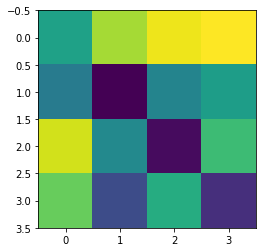

In [99]:
A = np.reshape(np.random.random(4*4),(4,4))

y_A = fft2(A)
y_c = np.fft.fft2(A)
A_c = ifft2(y_A).real

plt.imshow(A)

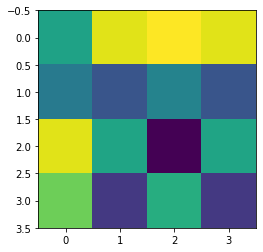

In [100]:
plt.imshow(A_c)

## FFT on Image

Apply your 2D-FFT on TIFF/JPG (lossless) Grayscale image and drop Fourier coefficients below some specified magnitude and save the 2D- image to a new file.
- ( relates to % compression – permanent Lossy compression)
- ( by sorting and retaining only coefficients greater than some(quantization) value. Rest are made 0.)

Apply 2D I-FFT, on the Quantized Grayscale image and render it to observe Image Quality.


983


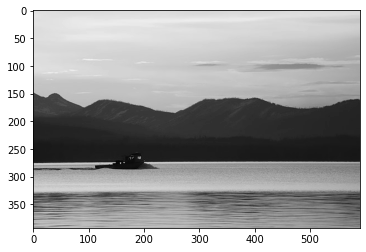

In [83]:
img = cv.imread('sample.jpeg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

print(sum(img.shape))

Starting conversion
Conversion Done
768


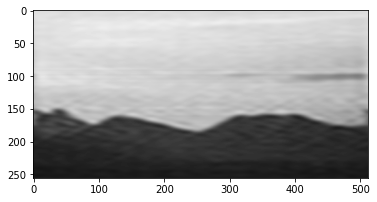

In [84]:
b_img = Jpeg_img(img, 99)
plt.imshow(b_img.render(), cmap='gray', vmin=0, vmax=255)

print(sum(b_img.shape))

In [86]:
print("Compression : ", (1-sum(b_img.shape)/sum(img.shape))*100, "%")

Compression :  21.87182095625636 %
